In [1]:
#https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch
#https://bobrupakroy.medium.com/lstms-for-regression-cc9b6677697f
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pylab import mpl, plt

import torch
import torch.nn as nn
import math

torch.manual_seed(8127)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/xwtan/anaconda3/envs/james/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
print(torch.version.cuda)

11.3


In [3]:
torch.cuda.is_available()

True

In [4]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

#We scrap from wikipedia the list of sp500 tickers to use for yahoo finance

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '').replace('.','-') for s in tickers]

In [144]:
#Run this if needed. Download data from yahoo finance

data_px = yf.download(tickers, data_source='yahoo', start = '2010-01-01', end = '2022-10-31',timeout=5)
data_px.to_pickle('data_prices.pkl')


[*********************100%***********************]  502 of 502 completed


In [145]:
data_px=pd.read_pickle('data_prices.pkl')
data_px = data_px['Adj Close']
data_px = data_px.fillna(method='ffill')
data_px = data_px[data_px.index>='2010-01-03'] #Using data too long ago might not be wise. due to structural/regime change in financial markets.
data_px = data_px[data_px.index<'2022-10-01']
data_px = data_px[data_px.columns[(~np.isnan(data_px.iloc[0]))]] #So we start around 2011


In [147]:
#Generate price features
# Lag
# And Average Price (Typical CTA uses crossover strategy of different frequency)

data_px_features = None
for asset_i in range(data_px.shape[1]-1):
    
    temp = data_px.iloc[:,asset_i:asset_i+1].copy()
    temp.columns=['PX']
    temp['rtn'] = ((temp.iloc[:,0]/temp.iloc[:,0].transform(lambda x: x.shift(1)))-1)
    for i in (1,5,21,21*3,21*6,252):
        temp['lag_'+str(i)] = temp.iloc[:,0].transform(lambda x: x.shift(i))
        if (i==1):
            continue
        #temp['rolling_mean_'+str(i)] = temp.iloc[:,1].transform(lambda x: x.shift(28).rolling(i).mean())
        #temp['rolling_std_'+str(i)]  = temp.iloc[:,1].transform(lambda x: x.shift(28).rolling(i).std())
        temp['rolling_meanpx_'+str(i)] = temp.iloc[:,0].transform(lambda x: x.rolling(i).mean())
    
    temp['ticker'] = data_px.columns[asset_i]
    temp['date'] = data_px.iloc[:,asset_i:asset_i+1].index
    temp = temp.iloc[np.where(~temp.isnull().any(axis=1))[0][0]:]
    
    if data_px_features is None:
        data_px_features = temp
    else:
        data_px_features = pd.concat([data_px_features,temp],axis=0,ignore_index=True)
    print(data_px_features.shape)


data_px_features['date'] = data_px_features['date'].dt.date
date_index = list(np.sort(data_px_features['date'].unique()))
data_px_features['date_index']  = [date_index.index(i) for i in data_px_features['date'] ]


(2957, 15)
(5914, 15)
(8871, 15)
(11828, 15)
(14785, 15)
(17742, 15)
(20699, 15)
(23656, 15)
(26613, 15)
(29570, 15)
(32527, 15)
(35484, 15)
(38441, 15)
(41398, 15)
(44355, 15)
(47312, 15)
(50269, 15)
(53226, 15)
(56183, 15)
(59140, 15)
(62097, 15)
(65054, 15)
(68011, 15)
(70968, 15)
(73925, 15)
(76882, 15)
(79839, 15)
(82796, 15)
(85753, 15)
(88710, 15)
(91667, 15)
(94624, 15)
(97581, 15)
(100538, 15)
(103495, 15)
(106452, 15)
(109409, 15)
(112366, 15)
(115323, 15)
(118280, 15)
(121237, 15)
(124194, 15)
(127151, 15)
(130108, 15)
(133065, 15)
(136022, 15)
(138979, 15)
(141936, 15)
(144893, 15)
(147850, 15)
(150807, 15)
(153764, 15)
(156721, 15)
(159678, 15)
(162635, 15)
(165592, 15)
(168549, 15)
(171506, 15)
(174463, 15)
(177420, 15)
(180377, 15)
(183334, 15)
(186291, 15)
(189248, 15)
(192205, 15)
(195162, 15)
(198119, 15)
(201076, 15)
(204033, 15)
(206990, 15)
(209947, 15)
(212904, 15)
(215861, 15)
(218818, 15)
(221775, 15)
(224732, 15)
(227689, 15)
(230646, 15)
(233603, 15)
(236560, 

In [148]:
#data starts 2011
#2011 to 2019 (Train), 2020,2021,2022 (Backtest)
data_px_features


,PX,rtn,lag_1,lag_5,rolling_meanpx_5,lag_21,rolling_meanpx_21,lag_63,rolling_meanpx_63,lag_126,rolling_meanpx_126,lag_252,rolling_meanpx_252,ticker,date,date_index
0,27.204113,0.010862,26.911806,27.230103,27.035227,23.852318,25.871874,21.169584,23.815305,18.025654,21.369148,20.331636,21.154196,A,2011-01-03,0
1,26.950790,-0.009312,27.204113,26.963776,27.032630,24.345999,25.995912,21.461887,23.902430,18.558304,21.435755,20.110785,21.181339,A,2011-01-04,1
2,26.892324,-0.002169,26.950790,27.080698,26.994955,24.118645,26.127992,21.221550,23.992443,18.714195,21.500661,20.039330,21.208533,A,2011-01-05,2
3,26.944292,0.001932,26.892324,27.015741,26.980665,24.410955,26.248627,21.565826,24.077815,18.610273,21.566804,20.013344,21.236037,A,2011-01-06,3
4,27.035234,0.003375,26.944292,26.911806,27.005351,24.462921,26.371118,21.955563,24.158445,18.317961,21.635988,20.006853,21.263927,A,2011-01-07,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295161,265.859985,-0.008133,268.040009,291.209991,275.513995,330.140015,294.017616,309.829987,311.750634,425.660004,333.635555,559.479980,425.696309,ZBRA,2022-09-26,2952
1295162,264.950012,-0.003423,265.859985,285.649994,271.373999,308.160004,291.959997,302.209991,311.159205,422.279999,332.386904,548.580017,424.570793,ZBRA,2022-09-27,2953
1295163,271.350006,0.024155,264.950012,285.079987,268.628003,307.899994,290.219522,298.329987,310.730952,438.100006,331.063491,531.179993,423.539722,ZBRA,2022-09-28,2954
1295164,265.519989,-0.021485,271.350006,272.940002,267.144000,302.859985,288.441427,293.950012,310.279681,429.609985,329.761190,525.669983,422.507380,ZBRA,2022-09-29,2955


In [149]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back,scaler=None,y_scaler=None):
        
    ignore_columns = ['ticker','date','date_index']
    

    if scaler is None:
        print('Fitting X Scaler')
        scaler  = MinMaxScaler(feature_range=(-1, 1))
        scaler  = scaler.fit(stock.drop(ignore_columns,axis=1).values)
    if y_scaler is None:
        print('Fitting Y Scaler')
        y_scaler  = MinMaxScaler(feature_range=(-1, 1))
        y_scaler = y_scaler.fit(stock.iloc[:,:1].values)

    scaled_data = scaler.transform(stock.drop(ignore_columns,axis=1).values)
    scaled_y_data = y_scaler.transform(stock['PX'].values.reshape([-1,1]))


    total_look_back = look_back + oos_prediction_window

    x_train = None
    y_train = None
    index_train = None
    ticker_train = None


    #Because it is LSTM, we have to create rolling-window data
    for ticker in stock['ticker'].unique():

        stock_data = scaled_data[np.where(stock['ticker']==ticker)]
        stock_rtn_data = scaled_y_data[np.where(stock['ticker']==ticker)]
        print(ticker)


        data = []
        datay = []
        for index in range(len(stock_data) - look_back): 
            data.append(stock_data[index: (index + look_back)])        
                
        for index in range(len(stock_data) - look_back - oos_prediction_window): 
            datay.append(stock_rtn_data[(index+look_back): (index + look_back + oos_prediction_window),:1])

        data = np.array(data)
        datay = np.array(datay)
        
        padding = np.empty([21,21,1])
        padding[:] = np.nan
        datay = np.vstack([datay,padding])

        index_train_i = stock[stock['ticker']==ticker]['date_index']
        index_train_i = index_train_i[look_back:]

        ticker_train_i = np.repeat(np.array(ticker),index_train_i.shape[0]).reshape([-1,1])
        

        if x_train is None:
            x_train = data
            y_train = datay
            index_train = index_train_i
            ticker_train = ticker_train_i
            
        else:
            x_train = np.vstack([x_train,data])
            y_train = np.vstack([y_train,datay])
            index_train = np.vstack([index_train,index_train_i])
            ticker_train = np.vstack([ticker_train,ticker_train_i])
        
    
    #y_train = np.apply_along_axis(lambda x:((x[-1]/x[0])-1),1,y_train)
    #y_test = np.apply_along_axis(lambda x:((x[-1]/x[0])-1),1,y_test)

    index_train = index_train.reshape([-1,1])
    ticker_train = ticker_train.reshape([-1,1])
    
    return [index_train,ticker_train,x_train, y_train,scaler,y_scaler]

look_back = 21*3 # choose sequence length
oos_prediction_window = 21 #Our returns forecast are 1 month ahead

index_train,ticker_train,x_train, y_train,scaler,y_scaler = load_data(data_px_features, look_back)
np.save('x_train_scalem11.pkl',x_train)
np.save('y_train_scalem11.pkl',y_train)
np.save('index_train_scalem11.pkl',index_train)
np.save('ticker_train_scalem11.pkl',ticker_train)

#Load from cache
#Enable if needed
if (True==False):
    x_train = np.load('x_train_scalem11.pkl.npy')
    y_train = np.load('y_train_scalem11.pkl.npy')
    index_train = np.load('index_train_scalem11.pkl.npy')
    ticker_train = np.load('ticker_train_scalem11.pkl.npy')

    ignore_columns = ['ticker','date','date_index']
    scaler  = MinMaxScaler(feature_range=(-1, 1))
    scaler  = scaler.fit(data_px_features.drop(ignore_columns,axis=1).values)

    y_scaler  = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = y_scaler.fit(data_px_features.iloc[:,:1].values)


Fitting X Scaler
Fitting Y Scaler
A
AAL
AAP
AAPL
ABC
ABMD
ABT
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALK
ALL
AMAT
AMD
AME
AMGN
AMP
AMT
AMZN
ANSS
AON
AOS
APA
APD
APH
ARE
ATO
ATVI
AVB
AVGO
AVY
AWK
AXP
AZO
BA
BAC
BALL
BAX
BBWI
BBY
BDX
BEN
BF-B
BIIB
BIO
BK
BKNG
BKR
BLK
BMY
BR
BRK-B
BRO
BSX
BWA
BXP
C
CAG
CAH
CAT
CB
CBRE
CCI
CCL
CDNS
CE
CF
CHD
CHRW
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COST
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTRA
CTSH
CVS
CVX
D
DAL
DD
DE
DFS
DG
DGX
DHI
DHR
DIS
DISH
DLR
DLTR
DOV
DPZ
DRI
DTE
DUK
DVA
DVN
DXC
DXCM
EA
EBAY
ECL
ED
EFX
EIX
EL
ELV
EMN
EMR
EOG
EQIX
EQR
EQT
ES
ESS
ETN
ETR
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FAST
FCX
FDS
FDX
FE
FFIV
FIS
FISV
FITB
FMC
FRT
FTNT
GD
GE
GILD
GIS
GL
GLW
GOOG
GOOGL
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HD
HES
HIG
HOLX
HON
HPQ
HRL
HSIC
HST
HSY
HUM
IBM
ICE
IDXX
IEX
IFF
ILMN
INCY
INTC
INTU
IP
IPG
IRM
ISRG
IT
ITW
IVZ
J
JBHT
JCI
JKHY
JNJ
JNPR
JPM
K
KDP
KEY
KIM
KLAC
KMB
KMX
KO
KR
L
LDOS
LEN
LH
LHX
LIN
LKQ

In [151]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('index_train.shape = ',index_train.shape)
print('ticker_train.shape = ',ticker_train.shape)



x_train.shape =  (1267572, 63, 13)
y_train.shape =  (1267572, 21, 1)
index_train.shape =  (1267572, 1)
ticker_train.shape =  (1267572, 1)


In [152]:
#Add in macro variables
#These are forward looking indicators that may increase predictive power

#https://www.clevelandfed.org/indicators-and-data/inflation-nowcasting
data_macro = pd.read_csv('data_cpi_nc_all.csv')[['obs_date','CCPI_INFLATION_YoY','CPI_INFLATION_YoY']]
data_macro.columns=['Date','CCPI_INFLATION_YoY','CPI_INFLATION_YoY']

#https://en.macromicro.me/charts/3997/global-ofr-fsi
data_macro2 = pd.read_csv('data_ofr_all.csv')[['obs_date','ofr_usa','ofr_otherdm','ofr_em']]
data_macro2.columns=['Date','FSI_USA','FSI_DM','FSI,EM']

#https://en.macromicro.me/charts/22907/sp-sector-performance
data_macro3 = pd.read_csv('data_sp_all.csv')
data_macro3 = data_macro3[['obs_date']+list(data_macro3.columns[:-1][1:])]
data_macro3.columns = ['Date']+list(['SEC_'+s for s in data_macro3.columns[1:].str.upper()])

data_macro = pd.merge(data_macro,data_macro2,on="Date",how="outer")
data_macro = pd.merge(data_macro,data_macro3,on="Date",how="outer")
data_macro = data_macro[data_macro['Date']>='2014-01-03']
data_macro = data_macro.sort_values('Date')

data_macro = pd.merge(data_macro,pd.DataFrame({'Date':list(data_px.index.strftime('%Y-%m-%d'))}),on="Date",how="right")

data_macro = data_macro.fillna(method='ffill')
data_macro.index = pd.to_datetime(data_macro['Date'])
del data_macro['Date']

In [153]:
m_scaler  = MinMaxScaler(feature_range=(-1, 1))
m_scaled_macro = m_scaler.fit_transform(data_macro[data_macro.index>='2014-01-03'].values) #Macro data unfortuantely starts from 2014
m_scaled_macro = pd.DataFrame(m_scaled_macro)
m_scaled_macro.index = data_macro.index[data_macro.index>='2014-01-03']
data_macro.index = data_macro.index.date
m_scaled_macro.columns=data_macro.columns

# Backtesting the model assuming monthly rebalancing

In [14]:
import sys
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [15]:
#Our custom error function
def custom_weight_mae(output, target):
    
    wgt = (torch.arange(1,22)/torch.arange(1,22).sum()).to(device) #Note this is 21 days of weight even though it is 22

    loss = torch.matmul((torch.abs((output - target))),wgt).mean()
    return loss

def custom_weight_rmse(output, target):
    
    wgt = (torch.arange(1,22)/torch.arange(1,22).sum()).to(device) #Note this is 21 days of weight even though it is 22

    loss = torch.matmul(((output - target)**2),wgt).mean()**0.5
    return loss

#Our early stopper class
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
#Training Function
#for updates, LR must be smaller
#https://machinelearningmastery.com/update-neural-network-models-with-more-data/
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

def train_lstm_model(model,x_train,y_train,x_valid=None,y_valid=None,start_lr=1e-5,num_epochs=50,batch_size=256):

    
    #Parameters which can be tuned
    optimiser = torch.optim.RAdam(model.parameters(), lr=start_lr)
    scheduler = ReduceLROnPlateau(optimiser, 'min',factor=0.5,patience=3,min_lr =1e-8)
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    best_model = None
    
    hist = np.zeros(num_epochs)
    hist_val = np.zeros(num_epochs)
    
    
    #Prepare data
    BATCH_SIZE = batch_size
    train_dataset = TensorDataset(x_train, y_train)
    train_set = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    if (x_valid is not None):
        valid_dataset = TensorDataset(x_valid, y_valid)
        val_set = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)


    for t in range(num_epochs):

        model.train()
        for id_batch, (x_batch, y_batch) in enumerate(train_set):

            # Forward pass
            y_train_pred = model(x_batch)
            #print(f'y_train_pred = {y_train_pred.shape} y_batch = {y_batch.shape}')
            loss = custom_weight_rmse(y_train_pred, y_batch)
            del y_train_pred


            hist[t] += loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1) #Prevent exploding gradient

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()

            if id_batch % 100 == 0:
                loss, current =  hist[t]/(id_batch+1), (id_batch + 1)* len(x_batch)
                print(f"Epoch {t}. Cumulative Train loss: {loss:>7f}  [{current:>5d}/{len(train_set.dataset):>5d}]")        



        hist[t]/=(id_batch+1)
        torch.cuda.empty_cache()


        if (x_valid is not None):
        
            #Compute validation loss
            model.eval()
            val_loss =0
            for id_batch, (x_batch, y_batch) in enumerate(val_set):
                y_test_pred = model(x_batch)
                hist_val[t] += custom_weight_mae(y_test_pred, y_batch)
                del y_test_pred

            hist_val[t]/=(id_batch+1)
            print("Epoch ", t, "TRAIN-MSE: ", hist[t]," VAL-MSE:",hist_val[t],f" Best Val-MSE {np.min(hist_val[0:(t+1)])}   LR:",optimiser.param_groups[0]['lr'])
            
            
            if (hist_val[t]==np.min(hist_val[0:(t+1)])):
                print('Best Epoch. Setting Saved')
                best_model = model.state_dict()

            # Update Scheduler
            scheduler.step(val_loss)

            #Update Early Scheduler
            if early_stopper.early_stop(val_loss):
                print('[INFO] Early Stop triggered !')
                break
    if best_model is not None:
        model.load_state_dict(best_model)        
    return(model,hist,hist_val)


## Define Global LSTM Model

In [156]:
#####################
# Global LSTM
#####################
input_dim = 13 #Number of features x_train.shape[2]
hidden_dim = 32
num_layers = 2

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,dropout=0.2).to(device)

        # Readout layer
        self.fc = nn.Linear(hidden_dim,32).to(device)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 21).to(device)
        

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        #print(f'h0 size = {h0.size()}')

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        #print(f'c0 size = {c0.size()}')


        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        # out.size() --> 100, 10
        return out
    


    
global_lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
global_lstm_model.load_state_dict(torch.load('models/lstmv4_global_s1.pth'))
global_lstm_model.to(device)


print(global_lstm_model)



LSTM(
  (lstm): LSTM(13, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=21, bias=True)
)


## Define Local Asset Mixed Model

In [18]:
# Here we define our model as a class
class MixedModel(nn.Module):
    def __init__(self,global_lstm_model):
        
        super(MixedModel, self).__init__()
        #self.internal_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
        #self.internal_lstm.load_state_dict(torch.load('models/lstmv3.pth'))
        self.global_lstm_model = global_lstm_model
        self.global_lstm_model.train()

        # Readout layer
        self.macrol1 = nn.Linear(16,21).to(device)
        self.mrelu = nn.ReLU()
        self.do = nn.Dropout(p=0.2)
    

        self.fc = nn.Linear(21*2,21).to(device)
        craft_weight=torch.zeros([21,42])
        craft_weight[0:21,0:21]=torch.diag(torch.ones(21))
        self.fc.weight = torch.nn.Parameter(craft_weight.to(device))        
        self.fc.bias.data.fill_(0)
        #self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(32, 21).to(device)
        

    def forward(self, data_prices,data_macro):

        lstm_out = self.global_lstm_model(data_prices)
        macro_out = self.macrol1(data_macro)
        macro_out  = self.mrelu(macro_out)
        macro_out = self.do(macro_out)
        
        #print(lstm_out.shape)
        #print(macro_out.shape)
        
        combined_output = torch.hstack([lstm_out,macro_out])
        
        #print(combined_output.shape)
        
        out = self.fc(combined_output)
        #out = self.relu(out)
        #out = self.fc2(out)

        return out
    
    

## First train base models until 2019

In [ ]:
index_until_train = date_index.index(datetime.date(2019, 12, 31)) #Train until 2017
#index_until_valid = date_index.index(datetime.date(2019, 1, 2)) #Validate via 2018,2019


current_train_x = x_train[np.where(index_train<=index_until_train)[0],:,:]
current_train_x = torch.from_numpy(current_train_x).type(torch.Tensor).to(device)
current_train_y = y_train[np.where(index_train<=index_until_train)[0],:,:]
current_train_y = torch.from_numpy(current_train_y).type(torch.Tensor).to(device)
current_train_y = current_train_y.reshape([-1,21])

#current_valid_x = x_train[np.where((index_train<=index_until_valid) & (index_train>index_until_train))[0],:,:]
#current_valid_x = torch.from_numpy(current_valid_x).type(torch.Tensor).to(device)
#current_valid_y = y_train[np.where((index_train<=index_until_valid) & (index_train>index_until_train))[0],:,:]
#current_valid_y = torch.from_numpy(current_valid_y).type(torch.Tensor).to(device)
#current_valid_y = current_valid_y.reshape([-1,21])


global_lstm_model,hist,hist_val = train_lstm_model(model=global_lstm_model,
                                     x_train=current_train_x,
                                     y_train=current_train_y,
                                     start_lr=1e-4,
                                     num_epochs=10,
                                     batch_size=256)


#del current_train_x
#del current_train_y

torch.cuda.empty_cache()
torch.save(global_lstm_model.state_dict(),'models/lstmv4_global_s1.pth')

In [ ]:
plt.plot(hist[1:10], label="Training loss")
plt.legend()
plt.show()

# Second phase, Mixed model

In [19]:
import copy


def predict_individual_assets(global_lstm_model,until_date_index,nepoch=250,lr=1e-3):

    asset_predicted_returns = {}
    macro_data = m_scaled_macro[m_scaled_macro.index.date<=date_index[until_date_index]]
    macro_data = torch.from_numpy(macro_data.values).type(torch.Tensor).to(device)


    for tic in data_px_features['ticker'].unique():
        
        print(tic)

        model_i = MixedModel(global_lstm_model=copy.deepcopy(global_lstm_model))
        model_i.to(device)
        optimiser = torch.optim.RAdam(model_i.parameters(), lr=lr)


        price_i_data = x_train[np.where((index_train<=until_date_index) & (index_train>=date_index.index(datetime.date(2014, 1, 3)))
                                        & (ticker_train==tic))[0],:,:]
        price_i_data = torch.from_numpy(price_i_data).type(torch.Tensor).to(device)

        oos_i_data = price_i_data[-1,:,:]
        
        price_i_data = price_i_data[:-21]

        y_i_data = y_train[np.where((index_train<=until_date_index) & (index_train>=date_index.index(datetime.date(2014, 1, 3)))
                                        & (ticker_train==tic))[0],:,:]

        y_i_data = torch.from_numpy(y_i_data).type(torch.Tensor).to(device)
        y_i_data = y_i_data.reshape(y_i_data.shape[:-1])
        oos_r_data=  y_i_data[-1,]
        y_i_data = y_i_data[:-21]



        n_epochs_asset_i = nepoch   
        train_error = np.zeros(n_epochs_asset_i)

        for t in range(n_epochs_asset_i):

            # Forward pass
            model_i.train()
            y_train_pred = model_i(price_i_data, macro_data[:-21])
            loss = custom_weight_rmse(y_train_pred, y_i_data)
            #loss = loss_fn(y_train_pred, y_i_data)


            train_error[t] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            torch.nn.utils.clip_grad_norm_(model_i.parameters(), 1) #Prevent exploding gradient

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()

            if t % 10 == 0:
                print(f"Asset {tic} Epoch {t}. Cumulative Train loss: {loss:>7f}.")




        #Predict out of sample
        model_i.eval()
        global_lstm_model.eval()
        oos_price_predictions = model_i(oos_i_data.reshape([1,-1,13]), macro_data[-1:])
        oos_price_predictions_global = model_i.global_lstm_model(oos_i_data.reshape([1,-1,13]))
        
        asset_predicted_returns[tic] = {
            'predicted_global': y_scaler.inverse_transform(oos_price_predictions_global.detach().cpu()).reshape(-1),
            'predicted_finetuned': y_scaler.inverse_transform(oos_price_predictions.detach().cpu()).reshape(-1),
            'actual': y_scaler.inverse_transform(oos_r_data.detach().cpu().reshape(-1, 1)).reshape(-1)}


        
        actual_rtn = (asset_predicted_returns[tic]['actual'][-1]/asset_predicted_returns[tic]['actual'][0])-1
        predicted_rtn = (asset_predicted_returns[tic]['predicted_finetuned'][-1]/asset_predicted_returns[tic]['predicted_finetuned'][0])-1
        predicted_global_rtn = (asset_predicted_returns[tic]['predicted_global'][-1]/asset_predicted_returns[tic]['predicted_global'][0])-1
        
        asset_predicted_returns[tic]['actual_rtn'] = actual_rtn
        asset_predicted_returns[tic]['predicted_rtn'] = predicted_rtn
        asset_predicted_returns[tic]['predicted_global_rtn'] = predicted_global_rtn
        

        
         
        print(f'{tic} actual rtn = {actual_rtn}. predicted rtn = {predicted_rtn}, predicted_global_rtn = {predicted_global_rtn}')
        sys.stdout.flush()
        
        del oos_i_data
        del model_i
        del price_i_data
        del y_i_data

        
    return(asset_predicted_returns)




In [ ]:
month_end_dates = data_px.reset_index().groupby([(data_px.index.year),(data_px.index.month)])['Date'].max()
month_end_dates = month_end_dates.dt.date.values
month_end_dates = month_end_dates[month_end_dates>datetime.date(2019, 12, 31)]
prev_date_index = date_index.index(datetime.date(2019, 12, 31))


backtest_returns = {}
train_error = {}

In [173]:

import time
with redirect_output("lstm_train_log1.txt"):
    for date_i in month_end_dates:
        
        if date_i in backtest_returns:
            continue
        
        print(f'Date=={date_i}')
        current_date_index = date_index.index(date_i)

        #Predict expected returns    
        global_lstm_model.eval()
        backtest_returns[date_i] = predict_individual_assets(global_lstm_model,prev_date_index,nepoch=100,lr=1e-4)

        #Update model after observing new prices
        new_train_x = x_train[np.where((index_train<=current_date_index) & (index_train>prev_date_index))[0],:,:]
        new_train_x = torch.from_numpy(new_train_x).type(torch.Tensor).to(device)
        new_train_y = y_train[np.where((index_train<=current_date_index) & (index_train>prev_date_index))[0],:,:]
        new_train_y = torch.from_numpy(new_train_y).type(torch.Tensor).to(device)
        new_train_y = new_train_y.reshape([-1,21])
        
        if (not new_train_y.isnan().any()):
            print('[INFO] Updating Global model')
            global_lstm_model.train()
            global_lstm_model,hist,hist_val = train_lstm_model(model=global_lstm_model,
                                                 x_train=new_train_x,
                                                 y_train=new_train_y,
                                                 start_lr=1e-4*(1e-1), #So that old gradient dont get flushed out
                                                 num_epochs=10,
                                                 batch_size=256)
            train_error[date_i] = hist[-1]
            torch.save(global_lstm_model.state_dict(),f'models/lstmv4_global_s1_{current_date_index}.pth')


        prev_date_index = current_date_index
        print(datetime.datetime.now())



# Some model evaluations 

In [227]:
from scipy.stats import spearmanr
mae_local = []
mae_global = []

me_local = []
me_global = []

corr_local = []
corr_global = []

for date_i in month_end_dates:
    mae_local += [np.mean([np.abs(backtest_returns[date_i][x]['actual_rtn'] - backtest_returns[date_i][x]['predicted_rtn']) for x in backtest_returns[date_i].keys()])]
    mae_global += [np.mean([np.abs(backtest_returns[date_i][x]['actual_rtn'] - backtest_returns[date_i][x]['predicted_global_rtn']) for x in backtest_returns[date_i].keys()])]
    
    me_local += [np.mean([(backtest_returns[date_i][x]['actual_rtn'] - backtest_returns[date_i][x]['predicted_rtn']) for x in backtest_returns[date_i].keys()])]
    me_global += [np.mean([(backtest_returns[date_i][x]['actual_rtn'] - backtest_returns[date_i][x]['predicted_global_rtn']) for x in backtest_returns[date_i].keys()])]

    a = [backtest_returns[date_i][x]['actual_rtn'] for x in backtest_returns[date_i].keys()]
    b = [backtest_returns[date_i][x]['predicted_rtn'] for x in backtest_returns[date_i].keys()]
    c = [backtest_returns[date_i][x]['predicted_global_rtn'] for x in backtest_returns[date_i].keys()]
    spearmanr(a,b)    

    corr_local += [spearmanr(a,b)]
    corr_global += [spearmanr(a,c)]
    

In [228]:
np.mean(corr_local)

0.050187571089836305

In [229]:
np.mean(corr_global)

0.0941895882609622

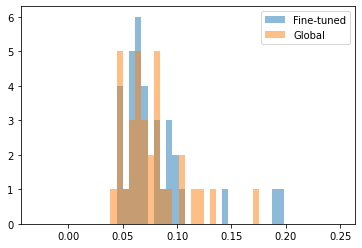

In [211]:
from matplotlib import pyplot
bins = np.linspace(-0.03, 0.25, 50)

pyplot.hist(mae_local, bins, alpha=0.5, label='Fine-tuned')
pyplot.hist(mae_global, bins, alpha=0.5, label='Global')
pyplot.legend(loc='upper right')
pyplot.show()

In [203]:
np.min(mae_local)

0.04687571156735693

In [201]:
np.median(mae_global)

0.06955760131087095

In [195]:
np.mean([np.abs(backtest_returns[date_i][x]['actual_rtn'] - backtest_returns[date_i][x]['predicted_rtn']) for x in backtest_returns[date_i].keys()])


0.0579026071821833

# Final prediction for out of sample

In [185]:
global_lstm_model.eval()
date_i = datetime.date(2022, 10, 31)
backtest_returns[date_i] = predict_individual_assets(global_lstm_model,len(date_index)-1,nepoch=100,lr=1e-4)


A
Asset A Epoch 0. Cumulative Train loss: 0.002913.
Asset A Epoch 10. Cumulative Train loss: 0.002179.
Asset A Epoch 20. Cumulative Train loss: 0.002121.
Asset A Epoch 30. Cumulative Train loss: 0.002062.
Asset A Epoch 40. Cumulative Train loss: 0.002013.
Asset A Epoch 50. Cumulative Train loss: 0.002017.
Asset A Epoch 60. Cumulative Train loss: 0.001990.
Asset A Epoch 70. Cumulative Train loss: 0.001954.
Asset A Epoch 80. Cumulative Train loss: 0.001926.
Asset A Epoch 90. Cumulative Train loss: 0.001931.
A actual rtn = nan. predicted rtn = 0.0013461047646732283, predicted_global_rtn = -0.0365657102885536
AAL
Asset AAL Epoch 0. Cumulative Train loss: 0.002143.
Asset AAL Epoch 10. Cumulative Train loss: 0.001887.
Asset AAL Epoch 20. Cumulative Train loss: 0.001706.
Asset AAL Epoch 30. Cumulative Train loss: 0.001627.
Asset AAL Epoch 40. Cumulative Train loss: 0.001614.
Asset AAL Epoch 50. Cumulative Train loss: 0.001552.
Asset AAL Epoch 60. Cumulative Train loss: 0.001541.
Asset AAL Epo

In [234]:
import pickle
with open('expected_returns.pkl', 'wb') as handle:
    pickle.dump(backtest_returns, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [231]:
backtest_returns[datetime.date(2022, 10, 31)]

{'A': {'predicted_global': array([121.51004759, 123.33547612, 120.73005464, 127.22389988,
         118.31230732, 122.7964234 , 119.91224278, 120.82948465,
         120.69987053, 120.37210659, 120.19597342, 121.02230786,
         121.89409602, 120.04167935, 119.95379032, 118.11042888,
         116.9559754 , 117.91600769, 119.39840267, 118.53300644,
         117.06694639]),
  'predicted_finetuned': array([116.20545634, 117.40642887, 117.83806166, 118.44050101,
         114.85658167, 116.31021296, 116.81251209, 116.83861247,
         117.58273959, 116.42420237, 118.71269068, 116.62696858,
         117.98809445, 116.61897867, 117.25177969, 117.03889292,
         116.15911485, 118.37977768, 117.66476935, 117.03267855,
         116.36188106]),
  'actual': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan]),
  'actual_rtn': nan,
  'predicted_rtn': 0.0013461047646732283,
  'predicted_global_rtn': -0.0365657102885536},
 'AAL'